In [1]:
import tensorflow as tf
import keras
import os
import cv2

import numpy as np
from sklearn.metrics import accuracy_score
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input
from keras.applications.imagenet_utils import decode_predictions
from sklearn.model_selection import train_test_split



from tensorflow.keras.preprocessing import image_dataset_from_directory

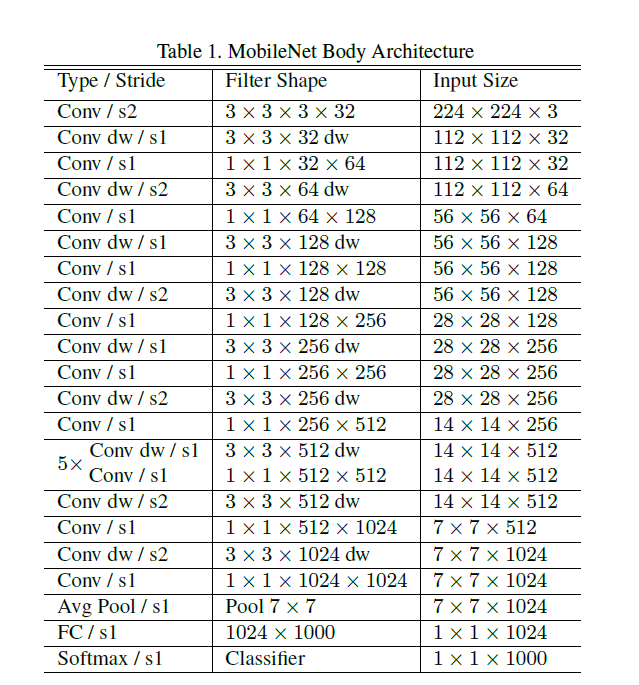

In [2]:

# Note: You may use tf.keras.layers.DepthwiseConv2D but you won't be able to add BatchNorm and LeakyReLU layers.
# Hence, we are first performing depthwise convolutions and then a Conv2D with kernel size of 1.
def SeparableConv( x , num_filters , strides , alpha=1.0 ):
    x = tf.keras.layers.DepthwiseConv2D( kernel_size=3 , padding='same' )( x )
    x = tf.keras.layers.BatchNormalization(momentum=0.9997)( x )
    x = tf.keras.layers.Activation( 'relu' )( x )
    x = tf.keras.layers.Conv2D( np.floor( num_filters * alpha ) , kernel_size=( 1 , 1 ) , strides=strides , use_bias=False , padding='same' )( x )
    x = tf.keras.layers.BatchNormalization(momentum=0.9997)(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x

def Conv( x , num_filters , kernel_size , strides=1 , alpha=1.0 ):
    x = tf.keras.layers.Conv2D( np.floor( num_filters * alpha ) , kernel_size=kernel_size , strides=strides , use_bias=False , padding='same' )( x )
    x = tf.keras.layers.BatchNormalization( momentum=0.9997 )(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x

# The number of classes are three.
num_classes = 2

# The shape of the input image.
inputs = tf.keras.layers.Input( shape=( 224, 224, 3 ) )






x = Conv( inputs , num_filters=32 , kernel_size=3 , strides=2 )
x = SeparableConv( x , num_filters=32 , strides=1 )
x = Conv( x , num_filters=64 , kernel_size=1 )
x = SeparableConv( x , num_filters=64 , strides=2  )

x = Conv( x , num_filters=128 , kernel_size=1 )
x = SeparableConv( x , num_filters=128 , strides=1  )
x = Conv( x , num_filters=128 , kernel_size=1 )
x = SeparableConv( x , num_filters=128 , strides=2  )
x = Conv( x , num_filters=256 , kernel_size=1 )
x = SeparableConv( x , num_filters=256 , strides=1  )
x = Conv( x , num_filters=256 , kernel_size=1 )
x = SeparableConv( x , num_filters=256 , strides=2  )
x = Conv( x , num_filters=512 , kernel_size=1 )


for i in range( 5 ):
    x = SeparableConv(x, num_filters=512 , strides=1 )
    x = Conv(x, num_filters=512 , kernel_size=1 )

x = SeparableConv(x, num_filters=512 , strides=2 )
x = Conv(x, num_filters=1024 , kernel_size=1 )
x = tf.keras.layers.AveragePooling2D( pool_size=( 7 , 7 ) )( x )
x = tf.keras.layers.Flatten()( x )
outputs = tf.keras.layers.Dense( num_classes,activation='softmax' )( x )
outputs=tf.keras.layers.Dropout(0.2)(outputs)
outputs = tf.keras.layers.Activation( 'softmax' )( outputs)

model = tf.keras.models.Model( inputs , outputs )
model.compile( loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam( learning_rate=0.001 ) , metrics=[ 'acc' ] )


In [3]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 112, 112, 32)      864       
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 112, 112, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 112, 112, 32)      0     

In [4]:
datadir="D:\datasets\own"
categories=['manish','not_manish']
img_size=224

In [5]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [6]:
train_data=[]
def create_training_data():
    for i in categories:
        path=os.path.join(datadir,i)
        class_num=categories.index(i)
        for img in os.listdir(path):
            #img1=data_augmentation(img)
            img_array=cv2.imread(os.path.join(path,img))
            # Add the image to a batch
            #img_array = tf.expand_dims(img_array, 0)
           
            img_size=224
            new_array =cv2.resize(img_array,(img_size,img_size))
            new_array = tf.expand_dims(new_array, 0)
        for i in range(500):
            
            img1=data_augmentation(new_array)
            train_data.append([new_array,class_num])
            
create_training_data()

In [7]:
print(len(train_data))

1000


In [8]:
x=[]
y=[]
for features,labels in train_data:
    x.append(features)
    y.append(labels)
x=np.array(x).reshape(-1,img_size,img_size,3)
y=np.array(y).reshape((-1,1))
print(y.shape)
#print(x)

(1000, 1)


In [9]:
x = x.astype('float32')
x /= 255

print(y.shape)
print(x.shape)

(1000, 1)
(1000, 224, 224, 3)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 4)

In [12]:
model.fit(X_train,y_train,epochs=1,validation_data=(X_test,y_test),shuffle=True)

25/25 [==============================] - 88s 4s/step - loss: 0.3436 - acc: 0.8163 - val_loss: 0.6932 - val_acc: 0.5000
